In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# split into words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from collections import Counter

import os
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First step:  load the description file (.csv) and have a look at it

**Remarks:**
It appears that the delimiter is not a default one, e.g. a space, but rather a semicolon.  We account for that while loading.

In [14]:
raw_csv_dir = '../data/raw/201802_sample_product_data.csv'
df = pd.read_csv(raw_csv_dir, sep=';', header=0)
df.head()

,sku,title,category,image_url
0,97060179,Schwarze Spinellkette mit 750- Bajonettverschluß,Schmuck > Ketten > Colliers,https://img02.nyris.io/demo/challenge/97060179...
1,106801871,Raute Diamant Messing Stecker Ohrstecker,Schmuck > Ohrschmuck > Ohrstecker,https://img02.nyris.io/demo/challenge/10680187...
2,89643247,Schildkrötenset mit Ohrringen und Kette kristall,Schmuck > Ketten > Gliederketten,https://img02.nyris.io/demo/challenge/89643247...
3,107668051,"Handgefertigtes Seidenband habotai, #254.6",Schmuck > Armbänder & Armreife > Wickelarmbänder,https://img02.nyris.io/demo/challenge/10766805...
4,10143554,Kettenanhänger Rosenblüte,Schmuck > Anhänger > Schmuckanhänger,https://img02.nyris.io/demo/challenge/10143554...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
sku          100000 non-null int64
title        99890 non-null object
category     100000 non-null object
image_url    100000 non-null object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [16]:
print('Number of unique skus')
print(df.sku.nunique())
print('')
print('Number of different titles')
print(df.title.nunique())
print('')
print('Number of different categories')
print(df.category.nunique())
print('')
print('Number of different urls')
print(df.image_url.nunique())

Number of unique skus
100000

Number of different titles
87776

Number of different categories
365

Number of different urls
100000


In [17]:
df.isna().sum()

sku            0
title        110
category       0
image_url      0
dtype: int64

In [18]:
print(df.title.isna().sum()/len(df)*100, '% of our samples miss a title')

0.11 % of our samples miss a title


## First results about the data

We find that the data consists of 100.000 samples each described by 
* a unique sku (int64) and 
* a unique url (string) 

(those values to be unique is plausible).  Furthermore, each sample has 

* a title (string)
* a category (string) which is an ensemble of subcategories

**Remarks:**
* We find 365 unique (sub)category ensembles
* 110 samples miss a title
* The title might be used later to enrich the information fed into the classifier.  Probably we will get rid of the 110 samples which miss this value.  Thereby, we lose less ~0.11 % of our data which is an acceptable trade-off for a first attempt.

# Next step:  expand the string-encoded category ensembles
by adding rows to the dataframe.  

This step is needed to gain some statistical insights into the distribution of samples among the different (sub)categories.

In [19]:
expanded_categories = df['category'].str.split(' > ')

expanded_categories holds now a list of subcategories originally encoded in the category string.

To enrich the dataframe by this information, we have to consider the number of subcategories originally encoded in the category string.  To this end, cound them:

In [20]:
expanded_categories.apply(lambda x: len(x)).value_counts()

3    100000
Name: category, dtype: int64

We find that each original category string consists of 3 (sub)categories.  With this insight we are safe to add this information to our dataframe by means of the following:

In [21]:
expanded_categories = expanded_categories.\
            apply(pd.Series).\
            rename({0: 'product_category', 
                    1: 'product_type', 
                    2: 'product_details'}, axis='columns')

In [22]:
df = df.join(expanded_categories)

Now our dataframe is ready to gain insight into the distribution of (sub)categories.  

# Step 3: investigate the distribution of (sub)categories

First, we want to see how many items belong to each of the product_category 

In [23]:
df['category_count'] = df.groupby(['category'])['category'].transform('count')
df['product_category_count'] = df.groupby(['product_category'])['product_category'].transform('count')
df['product_type_count'] = df.groupby(['product_type'])['product_type'].transform('count')
df['product_details_count'] = df.groupby(['product_details'])['product_details'].transform('count')

<function matplotlib.pyplot.show(*args, **kw)>

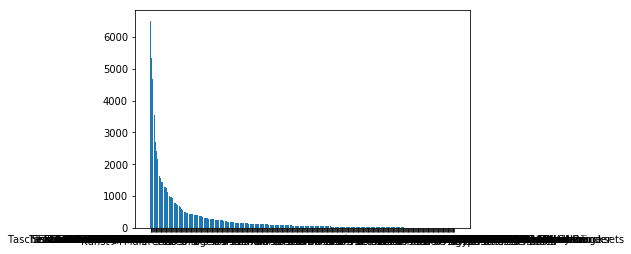

In [24]:
count = df['category'].value_counts().tolist()
lab = df['category'].value_counts().keys().tolist()

plt.bar(lab, count)
plt.show

In [13]:
def extract_data(data = df, cat1 = None, cat2 = None):
    temp = data['product_category'].value_counts()
    checksum = np.sum(temp)
    if cat1 != None:
        temp = data[data['product_category'] == cat1]['product_type'].value_counts()
        checksum = np.sum(temp)
        if cat2 != None:
            temp = data[(data['product_category'] == cat1) & 
                        (data['product_type'] == cat2)]['product_details'].value_counts()            
    
    labels = np.asarray(temp.keys().tolist())
    counts = np.asarray(temp.tolist())
    
    #veclen = np.vectorize(len)
    #label_length = veclen(labels)
    #assert np.sum(temp) == checksum
    #assert np.sum(label_length[label_length == 0]) == 0
    print(counts)
    median = np.percentile(counts, 50)
    mean = np.mean(counts)
    
    #print(df.loc[int(median)])
    
    return labels, counts, mean, median

In [14]:
def histogram_plot(data, cat1 = None, cat2 = None):   
    colors = ['#990000', '#009999', '#404040']   
    
    subplot_number = 1
    shown_categories = list(set(data['product_category'].values))
    
    if cat1 != None:
        subplot_number = len(shown_categories)        
        shown_categories = list(set(df[(df['product_category'] == cat1) & (df['product_type'] == cat2)]['product_details'].values))

    lengths = []
    counts = []
    f, ax = plt.subplots(len(shown_categories), sharex=False, figsize=(20,10))
    for i, cat in enumerate(shown_categories):
        if cat1 == None:
            l, c, mean, median = extract_data(data, cat)
        else:
            l, c, mean, median = extract_data(data, cat1, cat)
        #l, c, mean, median = prepare_data(column, cat)        
        lengths.append(l)
        counts.append(c)
        
        ax[i].bar(l, c, color = colors[i], label=cat)
        
        #ax[i].set_title(cat + ' title statistics', fontsize=15)
        ax[i].set_ylabel('counts', fontsize = 15)
        ax[i].legend(loc="upper left", fontsize=15)
        ax[i].tick_params(labelsize = 15)
        
        #ax[i].axvline(mean, color='black', linewidth=2)

histogram_plot(df, 'Kunst')
#df[(df['product_category'] == 'Schmuck') & (df['product_type'] == 'Ohrschmuck')]

<Figure size 1440x720 with 0 Axes>

[12605  9285  7280  3869  3528  3110  2458  1265   929   878   755   690
   591   536   435   408   329   197   187   163   161   156   121    62
     2]
2000.0 591.0


Text(0,0.5,'counts')

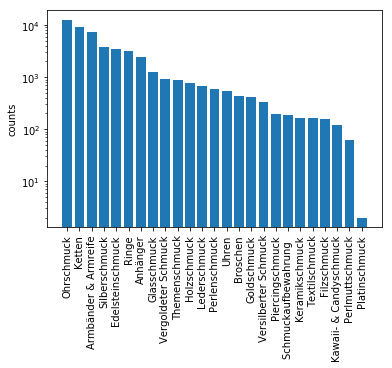

In [15]:
labels, counts, mean, median = extract_data(df, 'Schmuck')
print(mean, median)
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('counts')

In [25]:
plt.bar(*extract_data(df, 'Kunst', 'Drucke'))
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('counts')

NameError: name 'extract_data' is not defined

In [17]:
df['catcount'] = df.groupby(['category'])['category'].transform('count')

# Next step:  investigate a bit more on the title feature

We want to investigate the title feature in a bit more detail to get an idea if this information might be useful for further considerations.

As a first approach one might investigate the length of the title with respect to its frequency of occurence.  

The function prepare_data equalizes the length of each product category subset in order to plot the information encoded there.

In [18]:
df['length_title'] = df['title'].fillna('').apply(lambda x: len(x))

In [19]:
def prepare_data(column = 'title', product_category = None):
    title_lengths = df[column].fillna('').apply(lambda x: len(x))
    default_size = len(title_lengths.value_counts())

    if product_category != None:
        title_lengths = df[df['product_category'] == product_category][column].fillna('').apply(lambda x: len(x))
    
    mean = np.mean(title_lengths)
    median = np.percentile(title_lengths, 50)
    
    counter = title_lengths.value_counts()
    
    string_lengths = np.asarray(counter.keys().tolist())
    ix = np.argsort(string_lengths)
    string_lengths = string_lengths[ix]
    string_length_counts = np.asarray(counter.tolist())[ix]
    
    if len(ix) != default_size:
        temp = np.zeros((default_size), dtype=int)
        temp[string_lengths] = string_length_counts
        string_length_counts = temp
        string_lengths = np.arange(default_size)
        
    assert (len(string_lengths) == default_size)
    
    return string_lengths, string_length_counts, mean, median

Define the plotting function.  This function creates a histogram showing the *title lengths vs. counts* for each product category (Schmuck, Taschen, Kunst) as well as a comprehensive histogram.

In [20]:
def title_statistics(data = df, column = 'title'):    
    colors = ['#990000', '#009999', '#404040']   
    
    categories = list(set(data.product_category.values))
    
    f, ax = plt.subplots(4, sharex=True, figsize=(20,10))
    
    plt.title('Title statistics', fontsize=15)
    
    lengths = []
    counts = []
    p = []
   
    for i, cat in enumerate(categories):
        l, c, mean, median = prepare_data(column, cat)        
        lengths.append(l)
        counts.append(c)
        
        ax[i].bar(l, c, color = colors[i], label=cat)
        
        #ax[i].set_title(cat + ' title statistics', fontsize=15)
        ax[i].set_ylabel('counts', fontsize = 15)
        ax[i].legend(loc="upper left", fontsize=15)
        ax[i].tick_params(labelsize = 15)
        
        ax[i].axvline(median, color='black', linewidth=2)
        ax[i].axvline(mean, color='black', linewidth=2)

        # Add arrows annotating the means:
        for name, x0, xoff in zip(['Median', 'Mean'], [median, mean], [15, -15]):
            align = 'left' if xoff > 0 else 'right'
            ax[i].annotate(name+': {:0.2f}'.format(x0), xy=(x0, 1), xytext=(xoff, 10),
                    xycoords=('data', 'axes fraction'), textcoords='offset points',
                    horizontalalignment=align, verticalalignment='center',
                    arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                                    connectionstyle='angle,angleA=0,angleB=90,rad=10'),
                    )

        
    for i in reversed(range(len(counts))):        
        p.append(plt.bar(lengths[i], counts[i], 
                         bottom = np.sum([counts[j] for j in range(i)], axis=0), 
                         color = colors[i],
                         label = categories[i]))

    
    ax[3].set_title('overall title statistics', fontsize=15)
    ax[3].set_xlabel('title lengths', fontsize = 15)
    ax[3].set_ylabel('counts', fontsize = 15)
    ax[3].legend(loc="upper left", fontsize=15)
    ax[3].tick_params(labelsize = 15)
    
    plt.show()

Plot the title lengths vs. counts for each product category:

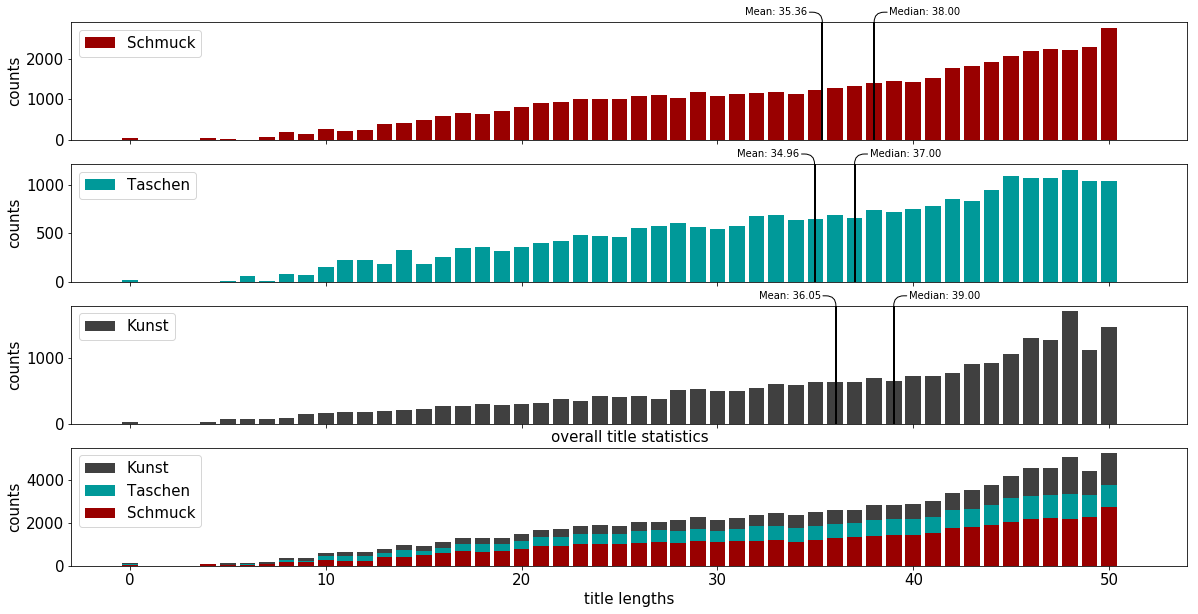

In [21]:
title_statistics(df, 'title')

## Intermediate results:  

From the histograms it becomes evient that maximum length of titles describing the products is 50 characters.  

The distributions are strongly left-skewed (dog food).  


# Next step:  clean the titles
As a next step, we'd like to clean the titles from 

* stop words
* words, that are not important for the content (deadlist)
* words, that are shorter than 3 characters
* words, that are composed from one and the same character (e.g. iii)

Furthermore we'd like to 

* reduce the words to their stemms
* transfer them into lower case representation
* transfer German umlauts into vowels
* reduce the words to their stemms


In [22]:
def cleaning(text):
    deadlist = ['mit', 'xxl', 'xxxl', 'uvp', 'xcm', 'grs', 'grm', 'grl', 'tlg','xxcm', 'xcm']
    transfer = {
        ord('ä'): 'ae',
        ord('ö'): 'oe',
        ord('ü'): 'ue',
        ord('ß'): 'ss'
    }
    # tokenize the text string
    tokens = word_tokenize(text)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # transfer German umlauts into vowels
    tokens = [w.translate(transfer) for w in tokens]
    
    # remove punctuation and digits from each word
    table = str.maketrans('', '', string.punctuation + string.digits)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]    

    # reduce words to their stemms
    porter = PorterStemmer()
    stemmed = list(set([porter.stem(word) for word in words]))
    
    # filter out 
    #   stop words, 
    #   words that are contained in the deadlist, 
    #   words that are shorter than 3 characters and 
    #   words which are assembled only from one and the same identical character
    stop_words = set(stopwords.words(['english', 'german']) + deadlist)
    words = [w for w in stemmed if not w in stop_words and len(w) > 2 and len(Counter(w)) > 1]
    
    # et voilà 
    return words

In [23]:
df['reduced_title'] = df['title'].fillna('').apply(lambda x: cleaning(x))
df['length_reduced_title'] = df['reduced_title'].apply(lambda x: len(x))

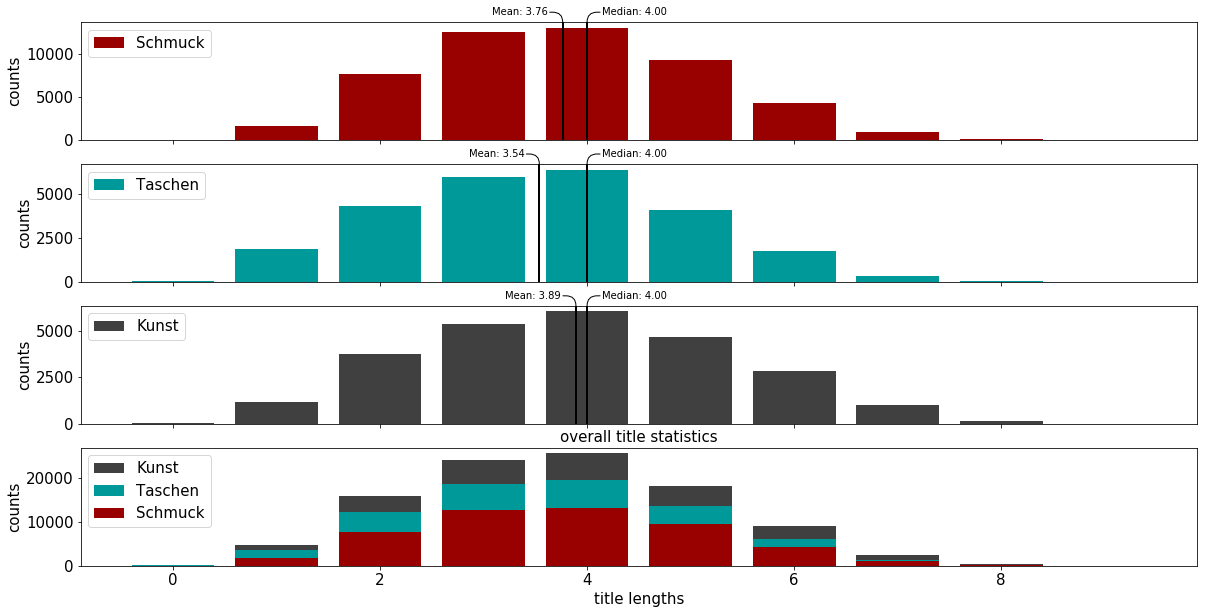

In [24]:
title_statistics(df, 'reduced_title')

## Intermediate results

These histograms look a lot more balanced.  In fact, they are almost Gaussian shaped, the maximum length is 8, the minimum length is 0 words, median and mean are close together.  

In [25]:
list_of_words = df['reduced_title'].apply(pd.Series).stack().value_counts()

In [26]:
len(list(set(list_of_words.keys())))

33985

In [27]:
df.columns

Index(['sku', 'title', 'category', 'image_url', 'product_category',
       'product_type', 'product_details', 'category_count',
       'product_category_count', 'product_type_count', 'product_details_count',
       'catcount', 'length_title', 'reduced_title', 'length_reduced_title'],
      dtype='object')

In [28]:
df['category'] = df['category'].astype('category')
df['product_category'] = df['product_category'].astype('category')
df['product_type'] = df['product_type'].astype('category')
df['product_details'] = df['product_details'].astype('category')

In [29]:
df['category'].cat.codes

0        164
1        196
2        167
3         66
4         54
5        223
6        237
7         49
8        186
9         84
10       155
11       244
12       223
13       216
14       237
15        57
16       177
17       237
18       223
19       194
20       177
21       170
22        65
23       194
24       294
25       120
26       244
27       196
28       203
29       195
        ... 
99970     17
99971      0
99972      0
99973      4
99974     17
99975      0
99976     36
99977      4
99978      0
99979      0
99980     47
99981     17
99982     17
99983      0
99984     11
99985     36
99986     36
99987      4
99988     17
99989      6
99990      6
99991      0
99992     22
99993     21
99994     10
99995      0
99996      4
99997      0
99998     12
99999     17
Length: 100000, dtype: int16

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [40]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}))   

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve

def train(classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
 
    classifier.fit(X_train, y_train)
    print("Accuracy: %s" % classifier.score(X_test, y_test))
    y_pred = classifier.predict(X_test)
    
    #print(confusion_matrix(y_test,y_pred))  
    #print(classification_report(y_test,y_pred))  
    #print(accuracy_score(y_test, y_pred))  
    #print(precision_recall_curve(y_test, y_pred))  
    
    return classifier

trial1 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier1', MultinomialNB()),
    #('classifier', (LogisticRegression(solver='sag')))
    #('classifier', RandomForestClassifier(random_state=0))#class_weight='balanced'))
    #('classifier', SVC())#kernel='linear', class_weight='balanced'))
])
 
dfclean = df.dropna()
dfclean['joined_rt'] = dfclean['reduced_title'].apply(lambda x: ' '.join(x))
clastitle = (train(trial1, dfclean.title, dfclean.product_details.cat.codes))
print('')
clasredtitle = (train(trial1, dfclean.joined_rt, dfclean.product_details.cat.codes))

/home/lisa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.4030352781003484



/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.40139350498538423


In [55]:
def train(classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
 
    classifier.fit(X_train, y_train)
    print("Accuracy: %s" % classifier.score(X_test, y_test))
    y_pred = classifier.predict(X_test)
    
    #print(confusion_matrix(y_test,y_pred))  
    #print(classification_report(y_test,y_pred))  
    #print(accuracy_score(y_test, y_pred))  
    #print(precision_recall_curve(y_test, y_pred))  
    
    return classifier

trial1 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    #('classifier1', MultinomialNB()),
    #('classifier', (LogisticRegression(solver='sag')))
    ('classifier', (OneVsRestClassifier(RandomForestClassifier(random_state=0), n_jobs=-1)))#class_weight='balanced'))
    #('classifier', SVC())#kernel='linear', class_weight='balanced'))
])
 
dfclean = df.dropna()
for cate in ['product_category', 'product_type', 'product_details']:
    dfclean['joined_rt'] = dfclean['reduced_title'].apply(lambda x: ' '.join(x))
    clastitle = (train(trial1, dfclean.title, dfclean[cate].cat.codes))
    print('')
    clasredtitle = (train(trial1, dfclean.joined_rt, dfclean[cate].cat.codes))

/home/lisa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.9652024186121011



/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.9558322988827934


/home/lisa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.7892523925839907



/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.7759980779241581


/home/lisa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.611099987987026



/home/lisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Accuracy: 0.6025307331918472


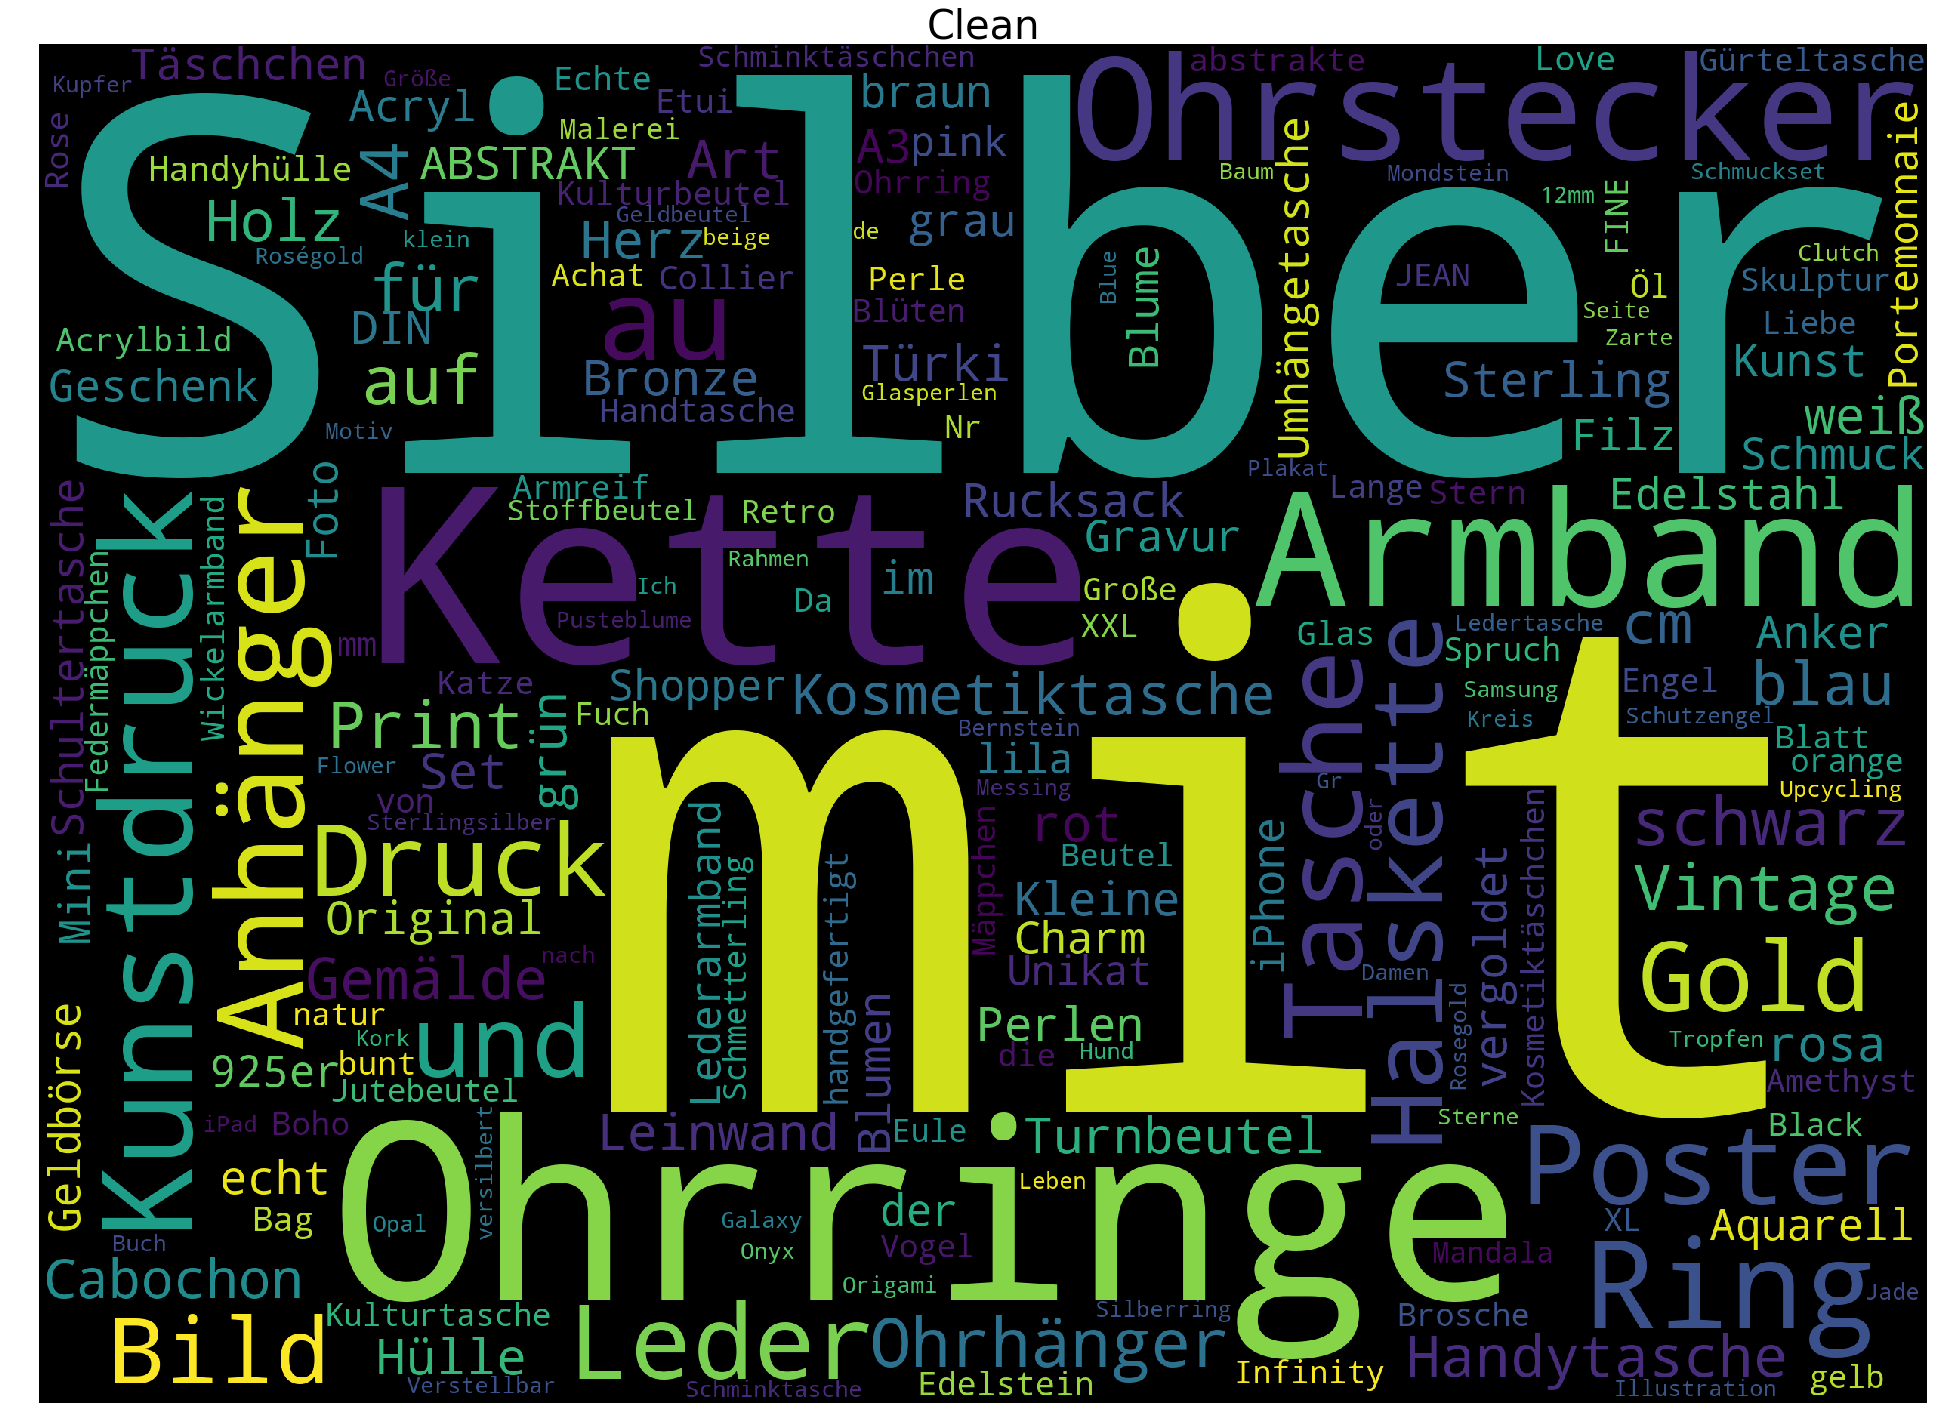

In [128]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# clean
subset = df.dropna()
text = subset.title.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic)

In [ ]:
class sentences_iter(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()
from gensim.models import Word2Vec

In [ ]:
sentences = sentences_iter('eng_news_2005_100K/') 
model = Word2Vec(sentences, size=int(100), window=20, min_count=5,hs=1)